# About

This Jupyter notebook contains the beginnings of our analysis code for the [PCAWG](https://dcc.icgc.org/pcawg) infrastructure paper.  This paper describes our efforts to run the core analysis for the project, namely the alignment workflow with 3 variant calling workflows.  We built various infrastructure components that let us do this in a distributed way across many (14) cloud and HPC environments.

The main text of the paper is currently in a private Google document.  This notebook will be used (maybe) to generate our figures if I can figure out how to program in Python!


In [7]:
%matplotlib inline

10 Longest Running Normals for BWA (icgc_specimen_id|icgc_sample_id|submitter_specimen_id|submitter_sample_id)
[('SP127702|SA557379|Tb188_Blood_DNA|EXTERN-MELA-20140924-028', 566.8733333333333), ('SP111840|SA529519|HX13L|HX13L', 465.2969444444444), ('SP112804|SA530455|CPCG0117-B1|CPCG0117-B1', 357.8644444444444), ('SP112810|SA530461|CPCG0124-B1|CPCG0124-B1', 316.81666666666666), ('SP102745|SA507170|C0005N|C0005N', 263.1227777777778), ('SP112808|SA530459|CPCG0123-B1|CPCG0123-B1', 258.01944444444445), ('SP112942|SA530585|CPCG0358-B1|CPCG0358-B1', 253.6363888888889), ('SP112814|SA530465|CPCG0128-B1|CPCG0128-B1', 251.16916666666665), ('SP103296|SA507138|C0085N|C0085N', 247.1302777777778), ('SP102632|SA506748|CPCG0102-B1|CPCG0102-B1', 241.47722222222222)]
10 Longest Running Tumors for BWA (icgc_specimen_id|icgc_sample_id|submitter_specimen_id|submitter_sample_id)
[('SP114898|SA538863|A10A-0015_CRUK_PC_0015_M1|A10A-0015_CRUK_PC_0015_M1_DNA', 578.661111111111), ('SP114920|SA538893|A22K-0016_C

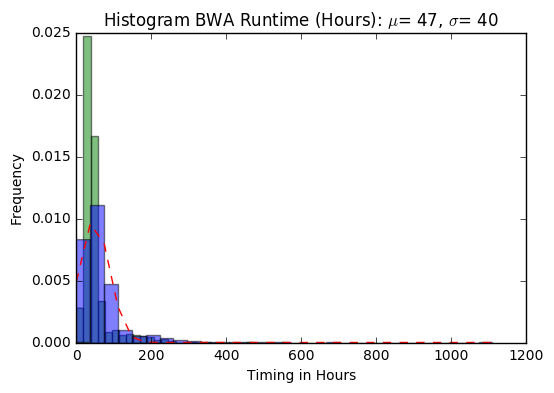

In [65]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import gzip
from io import StringIO
from io import BytesIO
import urllib
import json
import statistics
import traceback
import sys
import operator

# file content
file_content = ""

# https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_151215020209.small.jsonl.gz
# http://pancancer.info/gnos_metadata/latest/donor_p_151215020209.jsonl.gz
# https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz
# small
# request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_151215020209.small.jsonl.gz')
# large
request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz')
request.add_header('Accept-encoding', 'gzip')
response = urllib.request.urlopen(request)
buf = BytesIO( response.read())
f = gzip.GzipFile(fileobj=buf)
file_content = f.read()
request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.2.jsonl.gz')
request.add_header('Accept-encoding', 'gzip')
response = urllib.request.urlopen(request)
buf = BytesIO( response.read())
f = gzip.GzipFile(fileobj=buf)
file_content += f.read()

# BWA Analysis
bwa_normal_timing_list = []
bwa_tumor_timing_list = []

# timing hash
sorted_normal = {}
sorted_tumor = {}

for line in file_content.splitlines():
    json_struct = json.loads(line.decode(encoding='UTF-8'))
    #print(json_struct)
    #print(json_struct['normal_specimen'])
    
    try:
        bwa_normal_timing = 0
        submitter_specimen_id = json_struct['normal_specimen']['submitter_specimen_id']
        submitter_sample_id = json_struct['normal_specimen']['submitter_sample_id']
        icgc_specimen_id = json_struct['normal_specimen']['icgc_specimen_id']
        icgc_sample_id = json_struct['normal_specimen']['icgc_sample_id']
        name_str = icgc_specimen_id+"|"+icgc_sample_id+"|"+submitter_specimen_id+"|"+submitter_sample_id
        for timing in json_struct['normal_specimen']['alignment']['timing_metrics'] :
            #print(timing['metrics']['bwa_timing_seconds'])
            bwa_normal_timing += timing['metrics']['bwa_timing_seconds']
        #print(bwa_normal_timing)
        bwa_normal_timing_list.append(bwa_normal_timing/60/60)
        sorted_normal[name_str] = bwa_normal_timing/60/60
    except:
        pass
    try:
        bwa_tumor_timing = 0
        #print (json_struct['aligned_tumor_specimens'])
        for aligned_tumor in json_struct['aligned_tumor_specimens'] :
            submitter_specimen_id = aligned_tumor['submitter_specimen_id']
            submitter_sample_id = aligned_tumor['submitter_sample_id']
            icgc_specimen_id = aligned_tumor['icgc_specimen_id']
            icgc_sample_id = aligned_tumor['icgc_sample_id']
            name_str = icgc_specimen_id+"|"+icgc_sample_id+"|"+submitter_specimen_id+"|"+submitter_sample_id
            sorted_tumor[name_str] = bwa_tumor_timing/60/60
            for timing in aligned_tumor['alignment']['timing_metrics'] :
                bwa_tumor_timing += timing['metrics']['bwa_timing_seconds']
        #print(bwa_tumor_timing)
        bwa_tumor_timing_list.append(bwa_tumor_timing/60/60)
    except Exception as err:
        pass
    
print("10 Longest Running Normals for BWA (icgc_specimen_id|icgc_sample_id|submitter_specimen_id|submitter_sample_id)")
sorted_n = sorted(sorted_normal.items(), key=operator.itemgetter(1), reverse=True)
print (sorted_n[:10])
print("10 Longest Running Tumors for BWA (icgc_specimen_id|icgc_sample_id|submitter_specimen_id|submitter_sample_id)")
sorted_t = sorted(sorted_tumor.items(), key=operator.itemgetter(1), reverse=True)
print (sorted_t[:10])
print("BWA Timing Histogram")
#print(bwa_normal_timing_list)
#print(bwa_tumor_timing_list)

# histogram
mu = statistics.mean(bwa_normal_timing_list) # mean of distribution
sigma = statistics.stdev(bwa_normal_timing_list) # standard deviation of distribution
num_bins = 30
n, bins, patches = plt.hist(bwa_normal_timing_list, num_bins, normed=1, facecolor='green', alpha=0.5)
n, bins, patches = plt.hist(bwa_tumor_timing_list, num_bins, normed=1, facecolor='blue', alpha=0.5)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Timing in Hours')
plt.ylabel('Frequency')
plt.title(r"Histogram BWA Runtime (Hours): $\mu$=%3d, $\sigma$=%3d" % (mu, sigma))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

Longest Running Normal for Sanger (donor_unique_id)
PRAD-CA::CPCG0212,1575.0086111111111
UCEC-US::f6d136c7-c250-4361-9fed-50f513959a40,1479.4283333333333
RECA-EU::C0089,1407.3833333333334
BRCA-US::786e8dbe-442e-4551-87b3-b4c333b04dd4,1281.8236111111112
MELA-AU::MELA-0223,828.5161111111112
BRCA-UK::CGP_donor_1212361,824.17
PACA-CA::PCSI_0106,714.6741666666666
PACA-AU::ICGC_0088,689.9052777777778
PBCA-DE::ICGC_MB147,637.125
LINC-JP::HX31,602.8836111111111
RECA-EU::C0010,562.475
RECA-EU::C0012,552.4602777777778
LINC-JP::HX18,550.7916666666666
MELA-AU::MELA-0226,538.2705555555556
PBCA-DE::ICGC_MB12,537.9680555555556
PACA-CA::PCSI_0077,534.7111111111111
ESAD-UK::OCCAMS-AH-182,532.7783333333333
MALY-DE::4188879,525.5252777777778
CLLE-ES::684,519.1416666666667
READ-US::e6827400-0d95-46b0-8874-6ce9e9d5011b,518.4338888888889
ESAD-UK::OCCAMS-PS-001,502.3336111111111
BRCA-US::3fc3755d-a3f8-4e2c-813f-ff124f2a75c1,495.06
PACA-CA::PCSI_0175,489.89166666666665
ESAD-UK::OCCAMS-PS-013,486.4833333333333

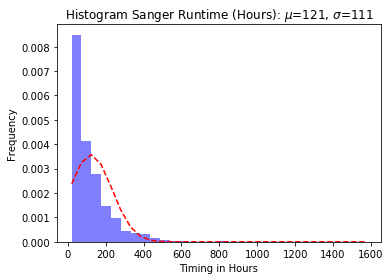

In [2]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import gzip
from io import StringIO
from io import BytesIO
import urllib
import json
import statistics
import traceback
import sys
import operator

# file content
file_content = ""

# https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_151215020209.small.jsonl.gz
# http://pancancer.info/gnos_metadata/latest/donor_p_151215020209.jsonl.gz
# https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz
# small
#request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_151215020209.small.jsonl.gz')
# large
request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz')
request.add_header('Accept-encoding', 'gzip')
response = urllib.request.urlopen(request)
buf = BytesIO( response.read())
f = gzip.GzipFile(fileobj=buf)
file_content = f.read()
request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.2.jsonl.gz')
request.add_header('Accept-encoding', 'gzip')
response = urllib.request.urlopen(request)
buf = BytesIO( response.read())
f = gzip.GzipFile(fileobj=buf)
file_content += f.read()

# multi-tumor
multi_tumor = {}
multi_tumor_list = 'https://raw.githubusercontent.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/develop/donor_multitumor.txt'
response = urllib.request.urlopen(multi_tumor_list)
data = response.read()      # a `bytes` object
text = data.decode('utf-8') # a `str`
for line in text.splitlines():
    line.rstrip("\n\r")
    multi_tumor[line] = True

# Sanger Analysis
timing_list = []

# timing hash
sorted_timing = {}

for line in file_content.splitlines():
    json_struct = json.loads(line.decode(encoding='UTF-8'))
    #print(json_struct)
    #print (type(json_struct['variant_calling_results']['sanger_variant_calling']['workflow_details']['variant_timing_metrics']))
    #print (json_struct['variant_calling_results']['sanger_variant_calling']['workflow_details']['variant_timing_metrics'].keys())
    try:
        donor_unique_id = json_struct['donor_unique_id']
        if donor_unique_id in multi_tumor.keys():
            #print ("MULTITUMOR FOUND!!!")
            continue
        submitter_specimen_id = json_struct['normal_specimen']['submitter_specimen_id']
        submitter_sample_id = json_struct['normal_specimen']['submitter_sample_id']
        icgc_specimen_id = json_struct['normal_specimen']['icgc_specimen_id']
        icgc_sample_id = json_struct['normal_specimen']['icgc_sample_id']
        #name_str = icgc_specimen_id+"|"+icgc_sample_id+"|"+submitter_specimen_id+"|"+submitter_sample_id
        name_str = donor_unique_id
        sanger_timing = 0
        timing = json_struct['variant_calling_results']['sanger_variant_calling']['workflow_details']['variant_timing_metrics']['workflow']['Wall_s']
        #print ("TIMING: " + str(timing))
        sanger_timing += timing
        #print(bwa_normal_timing)
        timing_list.append(sanger_timing/60/60)
        sorted_timing[name_str] = sanger_timing/60/60
    except:
        pass
    
#print("10 Longest Running Normal for Sanger (icgc_specimen_id|icgc_sample_id|submitter_specimen_id|submitter_sample_id)")
print("Longest Running Normal for Sanger (donor_unique_id)")
sorted_t = sorted(sorted_timing.items(), key=operator.itemgetter(1), reverse=True)
topn = sorted_t[:50]
for item in topn:
    print (item[0]+","+str(item[1]))
    
# now just dump this out to a file
f = open('sanger_timing.tsv', 'w')
for item in sorted_timing.keys():
    f.write(item+"\t"+str(sorted_timing[item])+"\n")
f.close()

print("Sanger Somatic Variant Timing Histogram")
#print(bwa_normal_timing_list)
#print(bwa_tumor_timing_list)

# histogram
mu = statistics.mean(timing_list) # mean of distribution
sigma = statistics.stdev(timing_list) # standard deviation of distribution
num_bins = 30
n, bins, patches = plt.hist(timing_list, num_bins, normed=1, facecolor='blue', alpha=0.5)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Timing in Hours')
plt.ylabel('Frequency')
plt.title(r"Histogram Sanger Runtime (Hours): $\mu$=%3d, $\sigma$=%3d" % (mu, sigma))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

Longest Running Normal for DKFZ/EMBL (donor_unique_id)
PRAD-CA::CPCG0354,392.1788888888889
LINC-JP::HX12,388.8333333333333
MELA-AU::MELA-0226,367.16416666666663
PACA-CA::PCSI_0047,266.7988888888889
LINC-JP::HX28,263.29333333333335
RECA-EU::C0002,259.33194444444445
PRAD-CA::CPCG0358,255.66611111111112
PACA-CA::PCSI_0235,248.76083333333332
RECA-EU::C0091,239.24166666666667
RECA-EU::C0010,238.7447222222222
PACA-CA::PCSI_0297,233.0538888888889
BOCA-UK::CGP_donor_1691206,226.88833333333332
RECA-EU::C0098,221.67055555555555
MELA-AU::MELA-0238,208.7813888888889
PACA-CA::PCSI_0509,204.43722222222223
PACA-CA::PCSI_0250,203.3086111111111
PACA-CA::PCSI_0290,202.50916666666666
PACA-CA::PCSI_0286,201.57222222222222
PACA-CA::PCSI_0326,201.42388888888888
PACA-CA::PCSI_0228,200.3838888888889
BRCA-UK::CGP_donor_1230722,200.1197222222222
LIRI-JP::RK047,199.81194444444446
RECA-EU::C0001,199.6913888888889
PACA-CA::PCSI_0325,197.4388888888889
PACA-CA::PCSI_0508,191.72777777777776
PACA-CA::PCSI_0324,189.360

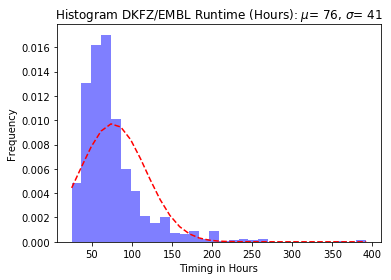

In [3]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import gzip
from io import StringIO
from io import BytesIO
import urllib
import json
import statistics
import traceback
import sys
import operator

# file content
file_content = ""

# https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_151215020209.small.jsonl.gz
# http://pancancer.info/gnos_metadata/latest/donor_p_151215020209.jsonl.gz
# https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz
# small
#request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_151215020209.small.jsonl.gz')
# large
#request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz')
request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz')
request.add_header('Accept-encoding', 'gzip')
response = urllib.request.urlopen(request)
buf = BytesIO( response.read())
f = gzip.GzipFile(fileobj=buf)
file_content = f.read()
request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.2.jsonl.gz')
request.add_header('Accept-encoding', 'gzip')
response = urllib.request.urlopen(request)
buf = BytesIO( response.read())
f = gzip.GzipFile(fileobj=buf)
file_content += f.read()

# multi-tumor
multi_tumor = {}
multi_tumor_list = 'https://raw.githubusercontent.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/develop/donor_multitumor.txt'
response = urllib.request.urlopen(multi_tumor_list)
data = response.read()      # a `bytes` object
text = data.decode('utf-8') # a `str`
for line in text.splitlines():
    line.rstrip("\n\r")
    multi_tumor[line] = True

# Sanger Analysis
timing_list = []

# timing hash
sorted_timing = {}

for line in file_content.splitlines():
    json_struct = json.loads(line.decode(encoding='UTF-8'))
    #print(json_struct['variant_calling_results']['dkfz_embl_variant_calling']['workflow_details']['variant_timing_metrics']['dkfz']['timing_metrics'][0]['workflow']['embl_timing_seconds'])
    try:
        timing = 0
        donor_unique_id = json_struct['donor_unique_id']
        if donor_unique_id in multi_tumor.keys():
            #print ("MULTITUMOR FOUND!!!")
            continue
        submitter_specimen_id = json_struct['normal_specimen']['submitter_specimen_id']
        submitter_sample_id = json_struct['normal_specimen']['submitter_sample_id']
        icgc_specimen_id = json_struct['normal_specimen']['icgc_specimen_id']
        icgc_sample_id = json_struct['normal_specimen']['icgc_sample_id']
        #name_str = icgc_specimen_id+"|"+icgc_sample_id+"|"+submitter_specimen_id+"|"+submitter_sample_id
        name_str = donor_unique_id
        embl_timing = json_struct['variant_calling_results']['dkfz_embl_variant_calling']['workflow_details']['variant_timing_metrics']['dkfz']['timing_metrics'][0]['workflow']['embl_timing_seconds']
        dkfz_timing = json_struct['variant_calling_results']['dkfz_embl_variant_calling']['workflow_details']['variant_timing_metrics']['dkfz']['timing_metrics'][0]['workflow']['dkfz_timing_seconds']
        #print ("TIMING: " + str(timing))
        timing = embl_timing + dkfz_timing
        #print(bwa_normal_timing)
        timing_list.append(timing/60/60)
        sorted_timing[name_str] = timing/60/60
    except:
        pass

#print("10 Longest Running Normal for DKFZ/EMBL (icgc_specimen_id|icgc_sample_id|submitter_specimen_id|submitter_sample_id)")
print("Longest Running Normal for DKFZ/EMBL (donor_unique_id)")
sorted_t = sorted(sorted_timing.items(), key=operator.itemgetter(1), reverse=True)
topn = sorted_t[:50]
for item in topn:
    print (item[0]+","+str(item[1]))

# now just dump this out to a file
f = open('dkfz_embl_timing.tsv', 'w')
for item in sorted_timing.keys():
    f.write(item+"\t"+str(sorted_timing[item])+"\n")
f.close()
    
print("DKFZ/EMBL Somatic Variant Timing Histogram")

# histogram
mu = statistics.mean(timing_list) # mean of distribution
sigma = statistics.stdev(timing_list) # standard deviation of distribution
num_bins = 30
n, bins, patches = plt.hist(timing_list, num_bins, normed=1, facecolor='blue', alpha=0.5)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Timing in Hours')
plt.ylabel('Frequency')
plt.title(r"Histogram DKFZ/EMBL Runtime (Hours): $\mu$=%3d, $\sigma$=%3d" % (mu, sigma))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

Longest Running Normal for Broad (donor_unique_id)
LIRI-JP::RK128,887.9975
PACA-CA::PCSI_0101,808.3105555555555
LIRI-JP::RK012,731.3836111111111
BRCA-US::9938ce5c-e74e-446e-a932-f096f85cc3b1,673.1127777777779
OV-AU::AOCS-108,515.2622222222222
PBCA-DE::ICGC_PA166,440.8430555555555
OV-AU::AOCS-115,427.60527777777776
OV-AU::AOCS-079,405.40222222222224
PACA-CA::PCSI_0106,396.8277777777778
OV-AU::AOCS-109,389.0097222222222
PACA-AU::ICGC_0021,382.81305555555554
PACA-CA::PCSI_0109,376.62166666666667
OV-AU::AOCS-111,371.3366666666667
PACA-CA::PCSI_0044,365.83888888888885
UCEC-US::5ffa2ec6-2d94-4b09-8fb9-3591cf38fa4f,363.04249999999996
LIRI-JP::RK093,342.84833333333336
UCEC-US::748e38b1-2ead-4a0a-8881-d640617b856b,332.9183333333333
PACA-CA::PCSI_0046,327.11583333333334
CESC-US::9aa36ac2-8418-4109-a3c1-63ca8742baab,324.48527777777775
THCA-US::c7a2f394-3e3f-4c90-9f1e-f2be3e5b0d6b,319.5588888888889
BRCA-US::e9f4f373-37a5-48ad-a1a0-b0d47820111a,308.87166666666667
BRCA-US::d8d7a6c2-6427-4f47-968c-6c

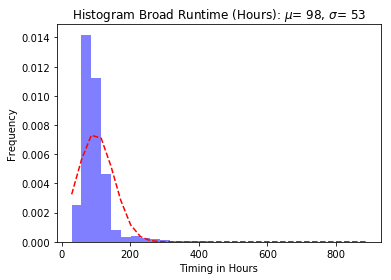

In [4]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import gzip
from io import StringIO
from io import BytesIO
import urllib
import json
import statistics
import traceback
import sys
import operator


# file content
file_content = ""

# https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_151215020209.small.jsonl.gz
# http://pancancer.info/gnos_metadata/latest/donor_p_151215020209.jsonl.gz
# https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz
# small
#request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_151215020209.small.jsonl.gz')
# large
#request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz')
request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.1.jsonl.gz')
request.add_header('Accept-encoding', 'gzip')
response = urllib.request.urlopen(request)
buf = BytesIO( response.read())
f = gzip.GzipFile(fileobj=buf)
file_content = f.read()
request = urllib.request.Request('https://github.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/raw/develop/donor_p_160408020209.2.jsonl.gz')
request.add_header('Accept-encoding', 'gzip')
response = urllib.request.urlopen(request)
buf = BytesIO( response.read())
f = gzip.GzipFile(fileobj=buf)
file_content += f.read()

# multi-tumor
multi_tumor = {}
multi_tumor_list = 'https://raw.githubusercontent.com/ICGC-TCGA-PanCancer/pcawg-infrastructure-paper/develop/donor_multitumor.txt'
response = urllib.request.urlopen(multi_tumor_list)
data = response.read()      # a `bytes` object
text = data.decode('utf-8') # a `str`
for line in text.splitlines():
    line.rstrip("\n\r")
    multi_tumor[line] = True

# Sanger Analysis
timing_list = []

# timing hash
sorted_timing = {}

for line in file_content.splitlines():
    json_struct = json.loads(line.decode(encoding='UTF-8'))
    #print(str(json_struct['variant_calling_results']['broad_variant_calling']['workflow_details']['variant_timing_metrics']['MuSE'][0]['runtime_seconds']))
    #['dkfz']['timing_metrics'][0]['workflow']['embl_timing_seconds'])
    #['MuSE', 'gatk_bqsr', 'cghub_genetorrent', 'gatk_indel', 'broad_variant_pipline']
    try:
        timing = 0
        donor_unique_id = json_struct['donor_unique_id']
        if donor_unique_id in multi_tumor.keys():
            #print ("MULTITUMOR FOUND!!!")
            continue
        #print (json_struct['variant_calling_results']['broad_variant_calling']['workflow_details']['variant_timing_metrics']['MuSE'][0]['runtime_seconds'])
        muse_timing = float(json_struct['variant_calling_results']['broad_variant_calling']['workflow_details']['variant_timing_metrics']['MuSE'][0]['runtime_seconds'])
        #print ("here!!!!!!!!")
        gatk_bqsr_timing = float(json_struct['variant_calling_results']['broad_variant_calling']['workflow_details']['variant_timing_metrics']['gatk_bqsr'][0]['runtime_seconds'])
        cghub_genetorrent_timing = float(json_struct['variant_calling_results']['broad_variant_calling']['workflow_details']['variant_timing_metrics']['cghub_genetorrent'][0]['runtime_seconds'])
        gatk_indel_timing = float(json_struct['variant_calling_results']['broad_variant_calling']['workflow_details']['variant_timing_metrics']['gatk_indel'][0]['runtime_seconds'])
        broad_variant_pipline_timing = float(json_struct['variant_calling_results']['broad_variant_calling']['workflow_details']['variant_timing_metrics']['broad_variant_pipline'][0]['runtime_seconds'])
        timing = muse_timing + gatk_bqsr_timing + gatk_indel_timing + broad_variant_pipline_timing
        submitter_specimen_id = json_struct['normal_specimen']['submitter_specimen_id']
        submitter_sample_id = json_struct['normal_specimen']['submitter_sample_id']
        icgc_specimen_id = json_struct['normal_specimen']['icgc_specimen_id']
        icgc_sample_id = json_struct['normal_specimen']['icgc_sample_id']
        name_str = donor_unique_id
        #name_str = icgc_specimen_id+"|"+icgc_sample_id+"|"+submitter_specimen_id+"|"+submitter_sample_id
        #print ("TIMING: " + str(timing))
        #print(bwa_normal_timing)
        timing_list.append(timing/60/60)
        sorted_timing[name_str] = timing/60/60
    except:
        #print ("Unexpected error:", sys.exc_info()[0])
        pass

#print("10 Longest Running Normal for Broad (icgc_specimen_id|icgc_sample_id|submitter_specimen_id|submitter_sample_id)")
print("Longest Running Normal for Broad (donor_unique_id)")
sorted_t = sorted(sorted_timing.items(), key=operator.itemgetter(1), reverse=True)
topn = sorted_t[:50]
for item in topn:
    print (item[0]+","+str(item[1]))
    
# now just dump this out to a file
f = open('broad_timing.tsv', 'w')
for item in sorted_timing.keys():
    f.write(item+"\t"+str(sorted_timing[item])+"\n")
f.close()

print("Broad Somatic Variant Timing Histogram")

# histogram
mu = statistics.mean(timing_list) # mean of distribution
sigma = statistics.stdev(timing_list) # standard deviation of distribution
num_bins = 30
n, bins, patches = plt.hist(timing_list, num_bins, normed=1, facecolor='blue', alpha=0.5)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
plt.plot(bins, y, 'r--')
plt.xlabel('Timing in Hours')
plt.ylabel('Frequency')
plt.title(r"Histogram Broad Runtime (Hours): $\mu$=%3d, $\sigma$=%3d" % (mu, sigma))

# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()